# 多层神经网络，Sequential 和 Module
通过前面的章节，我们了解到了机器学习领域中最常见的两个模型，线性回归模型和 Logistic 回归模型，他们分别是处理机器学习中最常见的两类问题-回归问题和分类问题。

下面我们会讲第一个深度学习的模型，多层神经网络。

## 多层神经网络
在前面的线性回归中，我们的公式是 $y = w x + b$，而在 Logistic 回归中，我们的公式是 $y = Sigmoid(w x + b)$，其实它们都可以看成单层神经网络，其中 Sigmoid 被称为激活函数，之后我们会详细介绍激活函数以及为什么必须使用激活函数，下面我们从理解神经网络入手。

### 理解神经网络
神经网络的灵感来自于人脑的神经元系统, 神经元通过突触接受输入，然后通过**神经激活**的方式传输给后面的神经元。这对比于右边的神经网络，首先接受数据输入，然后通过计算得到结果，接着经过**激活函数**，再传给第二层的神经元。

所以前面讲的 logistic 回归模型和线性回归模型都可以看做是一个单层神经网络，而 logistic 回归中使用了激活函数 sigmoid。

神经网络使用的激活函数都是非线性的，每个激活函数都输入一个值，然后做一种特定的数学运算得到一个结果，下面举几个例子

sigmoid 激活函数

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmgj7yto7gj308w05oa9w.jpg)

tanh 激活函数

$$tanh(x) = 2 \sigma(2x) - 1$$

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmgj8yjdnlj308w05mt8j.jpg)

ReLU 激活函数

$$ReLU(x) = max(0, x)$$

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmgj94ky2oj308n05uq2r.jpg)

我们下面重点讲一讲 ReLU 激活函数，因为现在神经网络中 90% 的情况都是使用这个激活函数。一般一个一层的神经网络的公式就是 $y = max(0, w x + b)$，一个两层的神经网络就是 $y = w_2\ max(0, w_1 x + b_1) + b_2$，非常简单，但是却很有效，使用这个激活函数能够加快梯度下降法的收敛速度，同时对比与其他的激活函数，这个激活函数计算更加简单，所以现在变得非常流行，之后你会发现我们激活在所有的神经网络中都会使用它。

## 神经网络的结构
神经网络就是很多个神经元堆在一起形成一层神经网络，那么多个层堆叠在一起就是深层神经网络，神经网络的结构其实非常简单，主要有输入层，隐藏层，输出层构成，输入层需要根据特征数目来决定，输出层根据解决的问题来决定，那么隐藏层的网路层数以及每层的神经元数就是可以调节的参数，而不同的层数和每层的参数对模型的影响非常大，我们看看这个网站的 [demo](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)

神经网络向前传播也非常简单，就是一层一层不断做运算就可以了

## 为什么要使用激活函数
激活函数在神经网络中非常重要，使用激活函数也是非常必要的，前面我们从人脑神经元的角度理解了激活函数，因为神经元需要通过激活才能往后传播，所以神经网络中需要激活函数，下面我们从数学的角度理解一下激活函数的必要性。

比如一个两层的神经网络，使用 A 表示激活函数，那么

$$
y = w_2 A(w_1 x)
$$

如果我们不使用激活函数，那么神经网络的结果就是

$$
y = w_2 (w_1 x) = (w_2 w_1) x = \bar{w} x
$$

可以看到，我们将两层神经网络的参数合在一起，用 $\bar{w}$ 来表示，两层的神经网络其实就变成了一层神经网络，只不过参数变成了新的 $\bar{w}$，所以如果不使用激活函数，那么不管多少层的神经网络，$y = w_n \cdots w_2 w_1 x = \bar{w} x$，就都变成了单层神经网络，所以在每一层我们都必须使用激活函数。

使用了激活函数之后，神经网络可以通过改变权重实现任意形状，越是复杂的神经网络能拟合的形状越复杂，这就是著名的神经网络万有逼近定理。

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) #np.meshgrid 建立坐标网格
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()]) # ravel: Return a contiguous flattened array.
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

In [10]:
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

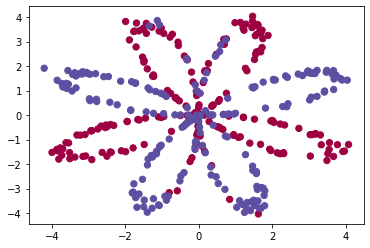

In [5]:
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

try use logistic regression first

In [11]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    return torch.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

for e in range(100):
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data.item()))

epoch: 20, loss: 0.6863625049591064
epoch: 40, loss: 0.6734480261802673
epoch: 60, loss: 0.6731650829315186
epoch: 80, loss: 0.6731512546539307
epoch: 100, loss: 0.6731480360031128


In [12]:
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    out = (out > 0.5) * 1
    return out.data.numpy()

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'logistic regression')

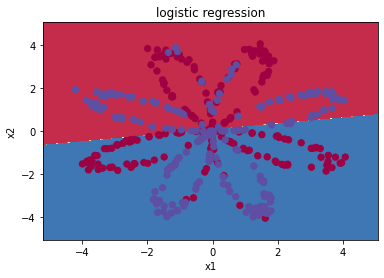

In [13]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

logistic model did not give good performance on this dataset, we can try nn now

In [18]:
# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.01) # 隐藏层神经元个数 2
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def two_network(x):
    x1 = torch.mm(x, w1) + b1
    x1 = torch.tanh(x1) # 使用 PyTorch 自带的 tanh 激活函数
    x2 = torch.mm(x1, w2) + b2
    return x2

optimizer = torch.optim.SGD([w1, w2, b1, b2], 1.)

criterion = nn.BCEWithLogitsLoss()

In [19]:
# 我们训练 10000 次
for e in range(10000):
    out = two_network(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data.item()))

epoch: 1000, loss: 0.28653252124786377
epoch: 2000, loss: 0.2732221782207489
epoch: 3000, loss: 0.2658802270889282
epoch: 4000, loss: 0.26030728220939636
epoch: 5000, loss: 0.23647186160087585
epoch: 6000, loss: 0.2261904925107956
epoch: 7000, loss: 0.22227118909358978
epoch: 8000, loss: 0.2197687178850174
epoch: 9000, loss: 0.2178819328546524
epoch: 10000, loss: 0.2163453847169876


In [20]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1, w2) + b2
    out = F.sigmoid(x2)
    out = (out > 0.5) * 1
    return out.data.numpy()

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, '2 layer network')

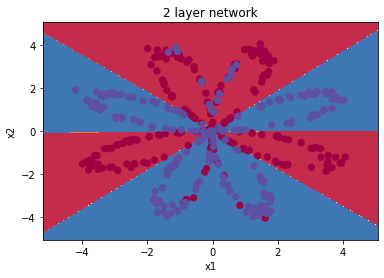

In [21]:
plot_decision_boundary(lambda x: plot_network(x), x.numpy(), y.numpy())
plt.title('2 layer network')

可以看到神经网络能够非常好地分类这个复杂的数据，和前面的 logistic 回归相比，神经网络因为有了激活函数的存在，成了一个非线性分类器，所以神经网络分类的边界更加复杂。

## Sequential 和 Module

我们讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

首先我们会讲一下 PyTorch 中的模块，Sequential 和 Module。


对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

In [22]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(4, 1)
)

In [23]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4, bias=True)

In [24]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
tensor([[ 0.0385,  0.1368],
        [-0.0982, -0.0530],
        [ 0.5946,  0.2272],
        [ 0.0338,  0.1132]], requires_grad=True)


In [25]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

print(param)

<generator object Module.parameters at 0x7f05717f6eb0>


In [27]:
# 我们训练 10000 次
for e in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data.item()))

epoch: 1000, loss: 0.271797776222229
epoch: 2000, loss: 0.26507142186164856
epoch: 3000, loss: 0.2604091167449951
epoch: 4000, loss: 0.25691547989845276
epoch: 5000, loss: 0.25431451201438904
epoch: 6000, loss: 0.252339631319046
epoch: 7000, loss: 0.2508033812046051
epoch: 8000, loss: 0.2495819479227066
epoch: 9000, loss: 0.24859210848808289
epoch: 10000, loss: 0.247776597738266


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些params初始化的问题在里面

In [28]:
def plot_seq(x):
    out = F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'sequential')

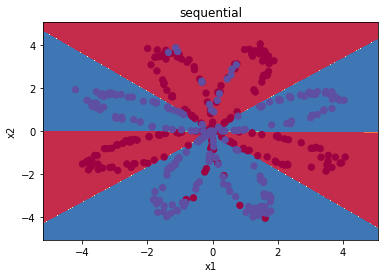

In [29]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

最后我们讲一讲如何保存模型，保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来，下面我们一一介绍。

In [34]:
# 将参数和模型保存在一起
torch.save(seq_net, 'save_seq_net.pth')

In [35]:
#上面就是保存模型的方式，`torch.save`里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth')
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [36]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[ -0.0464,  -9.9712],
        [  9.9671, -12.2506],
        [  9.6889,  11.1535],
        [ -0.8555,  -5.2179]], requires_grad=True)


我们可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式，只保存参数而不保存模型结构

In [37]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

In [38]:
#通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))

<All keys matched successfully>

In [39]:
print(seq_net2[0].weight)

Parameter containing:
tensor([[ -0.0464,  -9.9712],
        [  9.9671, -12.2506],
        [  9.6889,  11.1535],
        [ -0.8555,  -5.2179]], requires_grad=True)


有这两种保存和读取模型的方法，我们推荐使用**第二种**，因为第二种可移植性更强

下面我们再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [40]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [41]:
mo_net = module_net(2, 4, 1)

In [42]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4, bias=True)


In [43]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
tensor([[ 0.6093,  0.5494],
        [-0.6846,  0.4619],
        [ 0.3221,  0.1503],
        [-0.6326, -0.4812]], requires_grad=True)


In [44]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [46]:
# 我们训练 10000 次
for e in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data.item()))

epoch: 1000, loss: 0.2787899374961853
epoch: 2000, loss: 0.2712152302265167
epoch: 3000, loss: 0.2659180164337158
epoch: 4000, loss: 0.262227326631546
epoch: 5000, loss: 0.25954630970954895
epoch: 6000, loss: 0.25751298666000366
epoch: 7000, loss: 0.25591564178466797
epoch: 8000, loss: 0.2546241283416748
epoch: 9000, loss: 0.25355368852615356
epoch: 10000, loss: 0.2526468336582184


In [47]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')